In [1]:
import serial
import multiprocessing
from multiprocessing.shared_memory import SharedMemory
import time
import numpy as np
import random
from fastplotlib import Plot, GridPlot
from functools import partial
import time

In [2]:
# Sync & Mem Managers
def create_event_flags():
    generate_ef = multiprocessing.Event()
    acquire_ef = multiprocessing.Event()
    return generate_ef, acquire_ef

def create_mutex():
    mutex = multiprocessing.Lock()
    return mutex

# Initialize (Grid) Plot
def create_grid_plot():
    grid_shape = (1, 3)

    controllers = [
        [0, 1, 2]
    ]

    names = [
        ["red", "IR", "violet"]
    ]

    grid_plot = GridPlot(
        shape=grid_shape,
        controllers=controllers,
        names=names
    )

    return grid_plot

def create_plot():
    plot = Plot()
    return plot

def initialize_plot(plot):
    xs = [np.linspace(0,999,1000)]
    # ys = np.array((random.sample(range(0,1000), 1000)))
    ys = np.ones(1000)*np.linspace(0,1,1000)
    plot_data = np.dstack([xs,ys])[0]
    plot.add_line(data=plot_data, name='data', cmap='jet')
    data = np.vstack((xs,ys))
    plot.auto_scale(maintain_aspect=False)
    return data

def initialize_grid_plot(grid_plot):
    xs = [np.linspace(0,999,1000)]
    ys = np.array(np.random.randint(0,1000, size=(3,1000)))
    for i, subplot in enumerate(grid_plot):
        plot_data = np.dstack([xs, ys[i]])[0]
        subplot.add_line(data = plot_data, name='data', cmap='jet')
    data = np.vstack((xs, ys))
    return data

In [3]:
# Create Shared Memory Object
def create_shared_block(plot, grid_plot=False):
    if grid_plot:
        data = initialize_grid_plot(plot)
    else:
        data = initialize_plot(plot)
    shm = SharedMemory(create=True, size=data.nbytes)
    data_shared = np.ndarray(shape=data.shape, 
                             dtype=np.int64, buffer=shm.buf)
    data_shared[:] = data[:]
    return shm, data_shared
# Establish Serial Port Communication
def setup_serial(commport, baudrate):
    try:
        ser = serial.Serial(commport, baudrate, timeout=0.1)
        return ser
    except:
        print("Error in setting up serial port")

In [4]:
# Modify Data
def update_data(shm_name, mutex, ser):
    while True:
        shm = SharedMemory(shm_name)
        ys = ser.readline().decode().strip()
        mutex.acquire()
        data_shared = np.ndarray(shape=shape, dtype=dtype, buffer=shm.buf)
        xs = data_shared[0][-window_length:]
        data_shared[0][:-window_length] = data_shared[0][window_length:] - [window_length]
        data_shared[0][-window_length:] = xs
        for i in range(shape[0] - 1):
            data_shared[i+1][:-window_length] = data_shared[i+1][window_length:]
            data_shared[i+1][-window_length:] = ys[i]
        mutex.release()
        
def obtain_plot_data(shm_name, mutex, plot):
    shm = SharedMemory(shm_name)
    mutex.acquire()
    data_shared = np.ndarray(shape=shape, dtype=dtype, buffer=shm.buf)
    data = np.dstack([data_shared[0], data_shared[1]])[0]
    mutex.release()
    plot['data'].data = data
    plot.auto_scale(maintain_aspect=False)

def obtain_grid_plot_data(shm_name, mutex, grid_plot):
    shm = SharedMemory(shm_name)
    mutex.acquire()
    data_shared = np.ndarray(shape=shape, dtype=dtype, buffer=shm.buf)
    for i, subplot in enumerate(grid_plot):
        data = np.dstack([data_shared[0], data_shared[i+1]])[0]
        subplot['data'].data = data
    mutex.release()

RFBOutputContext()


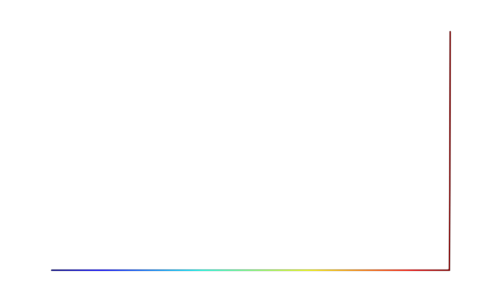

JupyterWgpuCanvas()

In [5]:
# Single Plot
## Initialize global vars
global shape, dtype, window_length
## Define how many data points you want to generate at a time
window_length=1
## Create plot and shared memory block
plot = create_plot()
shm, data = create_shared_block(plot)
## Define global vars
shape, dtype = data.shape, data.dtype
# Create mutex
mutex = create_mutex()
# Define Serial Port
ser = setup_serial('/dev/ttyACM0', 115200)
## Define process
p1 = multiprocessing.Process(name='update', 
                             target=update_data,
                             args=(shm.name, mutex, ser,))

## Start process and plotting
p1.start()
plot.add_animations(partial(obtain_plot_data, shm.name, mutex, plot,))
plot.show()

In [ ]:
plot.auto_scale(maintain_aspect=False)